# Check GPU options

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1709020284510466091
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6984105984
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17142679714650660044
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:06:00.0, compute capability: 7.5"
xla_global_id: 416903419
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 6913851392
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2437917695856920436
physical_device_desc: "device: 1, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:07:00.0, compute capability: 7.5"
xla_global_id: 2144165316
]


2022-01-04 23:06:14.499348: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-04 23:06:14.756277: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-04 23:06:14.756608: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-04 23:06:14.782160: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

# Import needed libraries

In [2]:
# Import general purpose python libraries
import os
import matplotlib.pyplot as plt
from PIL import Image # For handling the images
import numpy as np
from sklearn import metrics
import pandas as pd
# Import different Keras functionalities
import tensorflow as tf
from tensorflow import keras
from keras.constraints import maxnorm
from keras.utils import np_utils
from tensorflow.keras.optimizers import SGD,Adagrad
# from keras.optimizers import SGD,Adagrad
from keras import backend as K
#from keras.applications import ResNet50,Xception,VGG16,VGG19
from sklearn.model_selection import train_test_split

from plotcm import plotcm

####
# Where to save the figures
IMAGES_PATH = "../images"
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
from utils import saveFigures,write_json,create_json,load_previous_weights

from models import VGG16, MLP_model

# Load data

In [3]:
cifar10 = keras.datasets.cifar10
(X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()

X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=1)

X_train = X_train/255.
X_valid = X_valid/255.
X_test = X_test/255.

y_train = np_utils.to_categorical(y_train)
y_valid = np_utils.to_categorical(y_valid)
y_test = np_utils.to_categorical(y_test)

num_classes = y_test.shape[1]
class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

print("num_training_samples: ", X_train.shape)

num_training_samples:  (40000, 32, 32, 3)


# Configuration parameters
Configuration values of different parts of the solution. You should change some of them to obtain better results.

In [4]:
from datetime import datetime
# Randomize the initial network 
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


# Directory where to store weights of the model and results
now = datetime.now()
current_time = now.strftime("%d_%H_%M_%S")
experiment_rootdir = "./test/"+current_time+"/"
weights_path = experiment_rootdir +"weights.h5"
weights_best_path = experiment_rootdir +"weights_best.h5"
json_path = experiment_rootdir +"experiment.json"

# Create experiment directory if it does not exists
if not os.path.exists(experiment_rootdir):
    os.makedirs(experiment_rootdir)
print(experiment_rootdir)

./test/04_23_06_16/


In [5]:
# Parameters that configures the training process

# Tunable parameters
name_model = "MLP-10layers"
initial_lr = 5e-2

l2_reg = 0.0
dropout = 0.0

compile_parameters = { "metrics": ['accuracy'], "optimizer": SGD(learning_rate=initial_lr)}

# TODO


## Constant parameters
batch_size = 512 
epochs = 200
initial_epoch = 0 
num_classes = 10
dropout = 0.5

checkpoint_cb = keras.callbacks.ModelCheckpoint(weights_best_path,save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=25,restore_best_weights=True)
'''
optimizer=  = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
optimizer = keras.optimizers.Adagrad(learning_rate=0.001)
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
optimizer = keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
'''

parameters = {
    "name_model":name_model,
    "compile_parameters" :str(compile_parameters) ,
    "batch_size": batch_size,
    "epochs": epochs, 
    "initial_epoch":initial_epoch, 
    "initial_lr": initial_lr,
    "num_classes": num_classes,
    "dropout": dropout

}
create_json({"parameters":parameters}, json_path)


In [6]:
def trainModel(model,compile_parameters,X_train, y_train, validation_data, epochs, batch_size, experiment_rootdir, weights_path, json_path):
    model.compile(loss='categorical_crossentropy', optimizer=compile_parameters['optimizer'], metrics=compile_parameters['metrics'])
    print(model.summary())
    history = model.fit(x= X_train, y= y_train, validation_data = validation_data, epochs = epochs, batch_size= batch_size,callbacks=[checkpoint_cb, early_stopping_cb])
    model.save_weights(weights_path)
    hist_df = pd.DataFrame(history.history) 
    data = {"train_result2":hist_df.to_dict()}
    write_json(data,json_path)
    return history

# Training 

In [7]:
#Get model
model = MLP_model(10, num_classes=10, img_width=32, img_height=32, img_channels=3)

#load weights
load_previous_weights(model,weights_path)

#training model
val = (X_valid, y_valid)

history =trainModel(model,compile_parameters,X_train, y_train,val, epochs, batch_size,experiment_rootdir,weights_path,json_path)

saveFigures(experiment_rootdir, history, "accuracy", "loss")

Impossible to find weight path. Returning untrained model
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 940)               2888620   
                                                                 
 dense_1 (Dense)             (None, 846)               796086    
                                                                 
 dense_2 (Dense)             (None, 752)               636944    
                                                                 
 dense_3 (Dense)             (None, 658)               495474    
                                                                 
 de

2022-01-04 23:06:16.477339: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-04 23:06:16.477695: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-04 23:06:16.477993: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-04 23:06:16.478278: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-04 23:06:16.478562: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

Epoch 1/200
79/79 [==============================] - 2s 17ms/step - loss: 2.2483 - accuracy: 0.1598 - val_loss: 2.1305 - val_accuracy: 0.1841
Epoch 2/200
79/79 [==============================] - 1s 11ms/step - loss: 2.1249 - accuracy: 0.2057 - val_loss: 2.1610 - val_accuracy: 0.2066
Epoch 3/200
79/79 [==============================] - 1s 12ms/step - loss: 2.0295 - accuracy: 0.2551 - val_loss: 1.9368 - val_accuracy: 0.3143
Epoch 4/200
79/79 [==============================] - 1s 12ms/step - loss: 1.9571 - accuracy: 0.2903 - val_loss: 1.8822 - val_accuracy: 0.3161
Epoch 5/200
79/79 [==============================] - 1s 11ms/step - loss: 1.9071 - accuracy: 0.3117 - val_loss: 1.9937 - val_accuracy: 0.2425
Epoch 6/200
79/79 [==============================] - 1s 11ms/step - loss: 1.8657 - accuracy: 0.3239 - val_loss: 2.2280 - val_accuracy: 0.2288
Epoch 7/200
79/79 [==============================] - 1s 12ms/step - loss: 1.8323 - accuracy: 0.3377 - val_loss: 1.8580 - val_accuracy: 0.3140
Epoch 

<Figure size 432x288 with 0 Axes>

# Testing

-----------------------------------------------
Evaluation:
Average accuracy =  0.4707
-----------------------------------------------


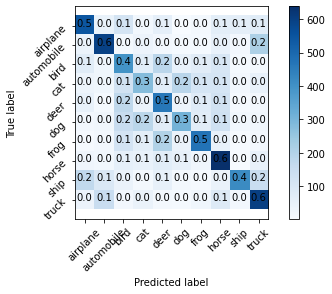

In [8]:
y_pred = np.argmax(model.predict(X_test), axis=1)
gt = np.argmax(y_test, axis=1)

# Evaluate predictions: Average accuracy and highest errors
print("-----------------------------------------------")
print("Evaluation:")
# Compute average accuracy
ave_accuracy = metrics.accuracy_score(gt, y_pred)
print('Average accuracy = ', ave_accuracy)
print("-----------------------------------------------")

# Visualize confusion matrix                                           
plotcm(experiment_rootdir, gt, y_pred,class_names, experiment_rootdir, normalize=True)


data = {"test_accuracy":ave_accuracy}
write_json(data,json_path)

